In [2]:
#认证
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

gpg: keybox '/tmp/tmpurd26wvg/pubring.gpg' created
gpg: /tmp/tmpurd26wvg/trustdb.gpg: trustdb created
gpg: key AD5F235DF639B041: public key "Launchpad PPA for Alessandro Strada" imported
gpg: Total number processed: 1
gpg:               imported: 1
··········


In [0]:
#挂载云盘
!mkdir -p drive
!google-drive-ocamlfuse drive  -o nonempty

In [4]:
!pip install xgboost
import xgboost as xgb
import pandas as pd
import numpy as np

In [6]:
#读取数据
train_csv = pd.read_csv("drive/Colab_Notebooks/data/round1_ijcai_18_train_20180301.txt"," ")
test_csv = pd.read_csv("drive/Colab_Notebooks/data/round1_ijcai_18_test_a_20180301.txt"," ")
print(len(train_csv),len(test_csv))

478138 18371


In [37]:
train_pd = train_csv.drop_duplicates("instance_id").copy()
test_pd = test_csv.drop_duplicates("instance_id").copy()
print(len(train_csv),len(test_csv))

478138 18371


In [38]:
#补充时间数据
import time
train_pd['day']=train_pd.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x+3600*8)))
train_pd['hour']=train_pd.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x+3600*8)))
test_pd['day']=test_pd.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x+3600*8)))
test_pd['hour']=test_pd.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x+3600*8)))
train_pd["hour_period"] = (train_pd["hour"].astype(int)/8).astype(int)
test_pd["hour_period"] = (test_pd["hour"].astype(int)/8).astype(int)
#展示列名
print("columns length:",len(train_pd.columns))
print("列名：",train_pd.columns)
#时间列
train_time_list = sorted(train_pd["day"].unique())
print("时间序列：",train_time_list)

columns length: 30
列名： Index(['instance_id', 'item_id', 'item_category_list', 'item_property_list',
       'item_brand_id', 'item_city_id', 'item_price_level', 'item_sales_level',
       'item_collected_level', 'item_pv_level', 'user_id', 'user_gender_id',
       'user_age_level', 'user_occupation_id', 'user_star_level', 'context_id',
       'context_timestamp', 'context_page_id', 'predict_category_property',
       'shop_id', 'shop_review_num_level', 'shop_review_positive_rate',
       'shop_star_level', 'shop_score_service', 'shop_score_delivery',
       'shop_score_description', 'is_trade', 'day', 'hour', 'hour_period'],
      dtype='object')
时间序列： ['2018-09-18', '2018-09-19', '2018-09-20', '2018-09-21', '2018-09-22', '2018-09-23', '2018-09-24']


In [0]:
#贝叶斯平滑
import random
import scipy.special as special
class BayesianSmoothing(object):
    def __init__(self, alpha, beta):
        self.alpha = alpha
        self.beta = beta

    def sample(self, alpha, beta, num, imp_upperbound):
        sample = np.random.beta(alpha, beta, num)
        I = []
        C = []
        for clk_rt in sample:
            imp = random.random() * imp_upperbound # imp_upperbound广告展示次数上限，imp广告随机展示次数
            # imp = imp_upperbound 源代码有错
            clk = imp * clk_rt
            I.append(imp)
            C.append(clk)
        return I, C

    def update(self, imps, clks, iter_num, epsilon):
        for i in range(iter_num):
            new_alpha, new_beta = self.__fixed_point_iteration(imps, clks, self.alpha, self.beta)
            if abs(new_alpha-self.alpha)<epsilon and abs(new_beta-self.beta)<epsilon:
                break
            self.alpha = new_alpha
            self.beta = new_beta

    def __fixed_point_iteration(self, imps, clks, alpha, beta):
        numerator_alpha = 0.0
        numerator_beta = 0.0
        denominator = 0.0

        for i in range(len(imps)):
            numerator_alpha += (special.digamma(clks[i]+alpha) - special.digamma(alpha))
            numerator_beta += (special.digamma(imps[i]-clks[i]+beta) - special.digamma(beta))
            denominator += (special.digamma(imps[i]+alpha+beta) - special.digamma(alpha+beta))

        return alpha*(numerator_alpha/denominator), beta*(numerator_beta/denominator)


# 特征获取

##数据预处理
对所有数据进行预处理，用的Pandas中的get_dummies防止出现测试集中与训练集中one_hot对应不同的方式，sklearn的方式有点麻烦

In [0]:
train_pd = train_csv.drop_duplicates("instance_id").copy()
test_pd = test_csv.drop_duplicates("instance_id").copy()

#补充时间数据
import time
train_pd['day']=train_pd.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x+3600*8)))
train_pd['hour']=train_pd.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x+3600*8)))
test_pd['day']=test_pd.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x+3600*8)))
test_pd['hour']=test_pd.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x+3600*8)))
train_pd["hour_period"] = (train_pd["hour"].astype(int)/8).astype(int)
test_pd["hour_period"] = (test_pd["hour"].astype(int)/8).astype(int)

feature_list = []
all_data = pd.concat([train_pd,test_pd])
all_data["category"] =  list(map(lambda x:x.split(";")[1],all_data["item_category_list"]))
feature_one_hot = pd.get_dummies(
    all_data[["category","item_price_level","item_sales_level"]],
    columns=["category","item_price_level","item_sales_level"],
    prefix=["category","price_level","sales_level"]
)
#测试后发现item_pv_level贡献不大，且带来太多纬度，舍弃
feature_list += list(feature_one_hot.columns)
all_data = pd.concat([all_data,feature_one_hot],axis=1)


#重新替换train_pd，test_pd
train_pd = all_data[:len(train_pd)]
test_pd = all_data[len(train_pd):]
#分割线下测试和训练集
train_m = train_pd[(train_pd["day"]>='2018-09-18')&(train_pd["day"]<='2018-09-22')]
test_m = train_pd[(train_pd["day"]>='2018-09-23')]

#产品转化率的特征
train_m ,test_m = set_item_trade_ratio(train_m,test_m)
if "item_trade_ratio" not in feature_list:
  feature_list.append("item_trade_ratio")


##item_id相关特征

### 广告展现次数
以8小时为粒度(period_show_counts)

In [0]:
# def get_item_period_count(df):
#   ret = df.groupby(["item_id","hour_period","day"]).count()[["is_trade"]].copy()
#   ret = ret.reset_index(drop=False)
#   day_length = len(ret["day"].unique())
#   print(day_length)
#   period_show_counts = ret.groupby(["hour_period","item_id"]).sum()["is_trade"]/day_length
#   period_show_counts = period_show_counts.reset_index(drop=False).rename(columns={"is_trade":"period_show_counts"})
#   ret = pd.merge(df,period_show_counts,on=["hour_period","item_id"],how="left").fillna(0)
#   return ret
# #计算8小时广告展现次数
# train_m = get_item_period_count(train_m)
# test_m = get_item_period_count(test_m)
# if "period_show_counts" not in feature_list:
#   feature_list.append("period_show_counts")

###产品转化率
item_id的trade_ratio

In [0]:
def set_item_trade_ratio(train_df,test_df):
  #要用贝叶斯平滑
  bs = BayesianSmoothing(1, 1)
  I, C = bs.sample(500, 500, 1000, 100)
  bs.update(I, C, 1000, 0.0000000001)
  ret = train_df[["item_id","is_trade"]].copy()
  item_trade_ratio_pd = (ret.groupby("item_id").sum()["is_trade"]+bs.alpha)/\
    (ret.groupby("item_id").count()["is_trade"]+bs.alpha+bs.beta)
  trade_ratio_pd = item_trade_ratio_pd.reset_index(drop=False).rename(columns={"is_trade":"item_trade_ratio"})
  na_value = bs.alpha/(bs.alpha+bs.beta)
  train_df = pd.merge(train_df,trade_ratio_pd,on="item_id",how="left").fillna(na_value)
  test_df = pd.merge(test_df,trade_ratio_pd,on="item_id",how="left").fillna(na_value)
  return train_df,test_df


## 归一化

# 简单数据统计

## 基本数据统计

In [7]:
print('总样本个数:%d' % train_csv.instance_id.unique().shape[0])
print('当前正样本个数为： %d' % len(train_csv[train_csv.is_trade == 1]))
print('当前负样本个数为： %d' % len(train_csv[train_csv.is_trade == 0]))
print('当前商品个数:%d' % train_csv.item_id.unique().shape[0])
print('用户数量：%d' % train_csv.user_id.unique().shape[0])
print('商户数量：%d' % train_csv.shop_id.unique().shape[0])
print('商标数量：%d' % train_csv.item_brand_id.unique().shape[0])
print('广告最大等级为：%d' % max(train_csv['item_price_level']))
print('最大广告销量等级：%d' % max(train_csv['item_sales_level']))
print('最大广告收藏等级:%d' % max(train_csv['item_collected_level']))
print('最大浏览量等级:%d' % max(train_csv['item_pv_level']))
print('用户的预测年龄等级区间为 %d-%d' % (min(train_csv['user_age_level']),max(train_csv['user_age_level'])))
print('用户等级区间为%d-%d' % (min(train_csv['user_star_level']), max(train_csv['user_star_level'])))
print('最大店铺评价数量等级:%d' % max(train_csv['shop_review_num_level']))
print('最大店铺星级编号:%d' % max(train_csv['shop_star_level']))

总样本个数:478087
当前正样本个数为： 9021
当前负样本个数为： 469117
当前商品个数:10075
用户数量：197694
商户数量：3959
商标数量：2055
广告最大等级为：17
最大广告销量等级：17
最大广告收藏等级:17
最大浏览量等级:21
用户的预测年龄等级区间为 -1-1007
用户等级区间为-1-3010
最大店铺评价数量等级:25
最大店铺星级编号:5020


In [8]:
%%time
import time
train_csv['day']=train_csv.context_timestamp.apply(lambda x:time.strftime("%Y-%m-%d",time.localtime(x+3600*8)))
train_csv['hour']=train_csv.context_timestamp.apply(lambda x:time.strftime("%H",time.localtime(x+3600*8)))

CPU times: user 1.47 s, sys: 31 ms, total: 1.5 s
Wall time: 1.5 s


每天行为数量
2018-09-18    78268
2018-09-19    70931
2018-09-20    68387
2018-09-21    71199
2018-09-22    68318
2018-09-23    63614
2018-09-24    57421
Name: day, dtype: int64


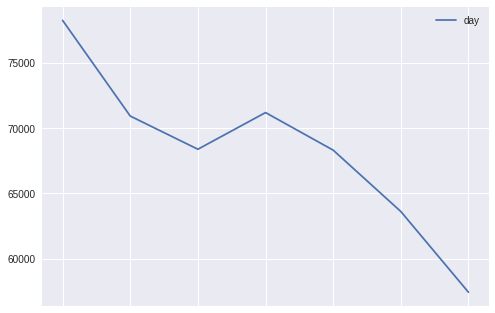

In [9]:
print('每天行为数量')
print(train_csv.day.value_counts().sort_index())
pd.DataFrame(train_csv.day.value_counts().sort_index()).plot()

## item_category_list的统计信息

item_category_list分割后长度最小值： 2  长度最大值： 3


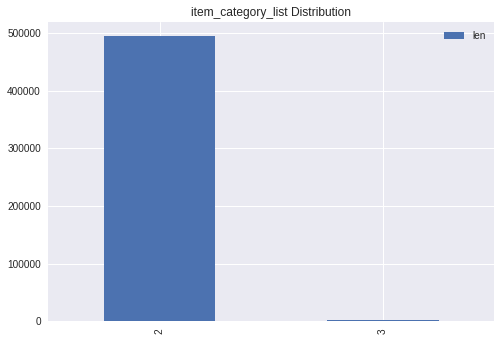

In [10]:
all_data = [train_csv,test_csv]
all_data = pd.concat(all_data)
category_list= list(map(lambda x:len(x.split(";")),all_data["item_category_list"]))
item_category_list = pd.DataFrame({"len":category_list,"list":list(map(lambda x:x.split(";"),all_data["item_category_list"]))})
print("item_category_list分割后长度最小值：",item_category_list["len"].min()," 长度最大值：",item_category_list["len"].max())
pd.DataFrame(item_category_list["len"].value_counts().sort_index()).plot(kind="bar",title="item_category_list Distribution")

## item_property_list的统计信息

item_category_list分割后长度最小值： 6  长度最大值： 100


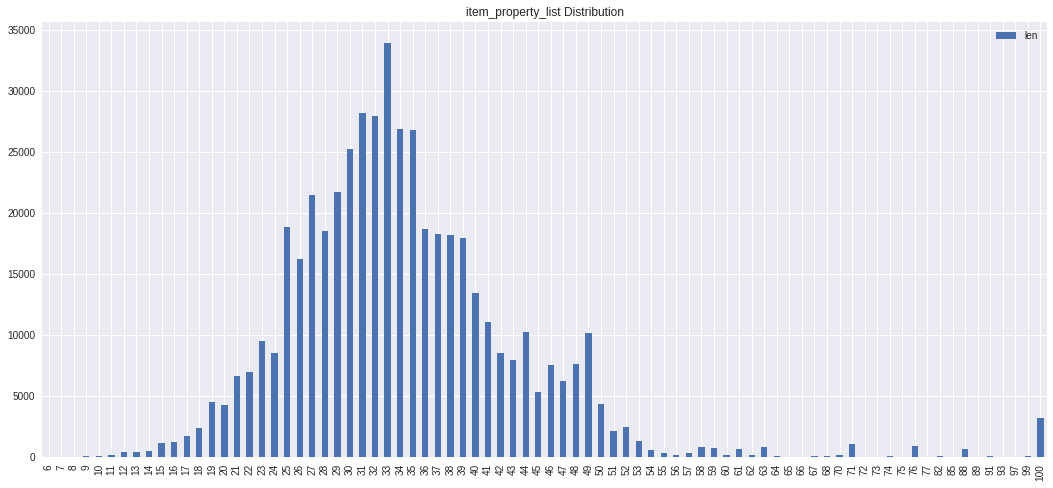

In [11]:
all_data = [train_csv,test_csv]
all_data = pd.concat(all_data)
property_list= list(map(lambda x:len(x.split(";")),all_data["item_property_list"]))
item_property_list = pd.DataFrame({"len":property_list,"list":list(map(lambda x:x.split(";"),all_data["item_property_list"]))})
print("item_category_list分割后长度最小值：",item_property_list["len"].min()," 长度最大值：",item_property_list["len"].max())
pd.DataFrame(item_property_list["len"].value_counts().sort_index()).plot(kind="bar",title="item_property_list Distribution",figsize=(18,8))

##数据分布

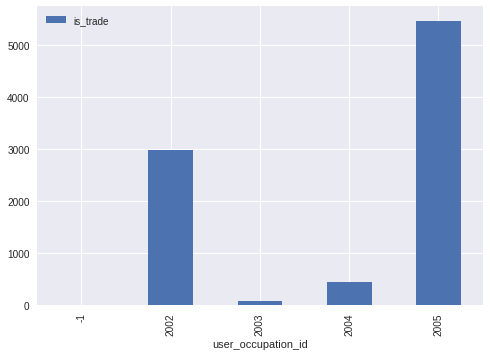

In [144]:
temp = train_pd.groupby("user_occupation_id").sum()
temp[["is_trade"]].plot(kind="bar")

# 计算特征

## 计算item_category_list所有类别信息对应的is_trade数目z-score
感觉区别度不算大，此特征不一定有太大作用

In [0]:
#传入DataFrame而获取对应category的is_trade数目表
def get_category_trade_score(df):
  temp_pd = df[["instance_id","item_category_list","is_trade","user_gender_id"]].copy()#返回的DataFrame
  #只留第2个category，第一个category都是一样的
  temp_pd["category"] =  list(map(lambda x:x.split(";")[1],temp_pd["item_category_list"]))
  #temp_pd.groupby(["category","user_gender_id"]).count().at[("1968056100269760729",1),"is_trade"]
  ret = temp_pd.groupby(["category","user_gender_id"]).sum()
  #ret["trade_ratio"] = ret["is_trade"]/len(df)#trade的比例
  ret["category_gender_trade_score"] = (ret["is_trade"]-ret["is_trade"].mean())/ret["is_trade"].std()#计算z-score
  ret = ret.reset_index()
  ret.set_index(["category","user_gender_id"],inplace=True,drop=False)
  return ret
#设定train和test表数据
def set_category_trade_score(df,score_table):
  ret = df[["instance_id","item_category_list","user_gender_id"]].copy()
  ret["category"] = list(map(lambda x:x.split(";")[1],ret["item_category_list"]))
  ret = pd.merge(ret,score_table,on=["category","user_gender_id"],how="left",suffixes=["","_r"]).fillna(0)[["instance_id","category_gender_trade_score"]].copy()
  df = pd.merge(df,ret,on="instance_id",how="left")
  return df

## 计算item_property_list对应的特征

In [14]:
%%time
def get_property_dict(df):
  ret = df[["user_gender_id","item_property_list","is_trade"]].copy()
  #下面这句骚操作把一行扩展成多行
  ret = ret.drop('item_property_list', axis=1).join(ret['item_property_list'].str.split(';', expand=True).stack().reset_index(level=1, drop=True).rename('item_property_list'))
  ret = ret.rename(columns={"item_property_list":"property"})
  ret = ret.groupby(["property","user_gender_id"]).count()
  ret = ret.reset_index()
  ret.set_index(["property","user_gender_id"],inplace=True,drop=False)
  ret["is_trade"] = ret["is_trade"]/ret["is_trade"].max()#归一化
  return ret
#这里怎么用没想好
property_pd = get_property_dict(train_pd)

CPU times: user 17.4 s, sys: 1.38 s, total: 18.8 s
Wall time: 18.8 s


##计算item_brand_id特征

In [0]:
def get_brand_feature(df):
  ret = df[["item_brand_id","is_trade"]].copy()
  ret = ret.groupby("item_brand_id").sum()
  ret["brand_total_count"] = df.groupby("item_brand_id").count()["is_trade"]
  ret["brand_trade_ratio"] = ret["is_trade"] / ret["brand_total_count"]
  ret["brand_total_ratio"] = ret["brand_total_count"]/ret["brand_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("item_brand_id",inplace=True,drop=False)
  ret = ret[["item_brand_id","brand_total_ratio","brand_trade_ratio"]]
  return ret
def set_brand_feature(df,brand_table):
  df = pd.merge(df,brand_table,on="item_brand_id",how="left")
  return df


##计算item_city_id的特征

In [0]:
def get_city_feature(df):
  ret = df[["item_city_id","is_trade"]].copy()
  ret = ret.groupby("item_city_id").sum()
  ret["city_total_count"] = df.groupby("item_city_id").count()["is_trade"]
  ret["city_trade_ratio"] = ret["is_trade"] / ret["city_total_count"]
  ret["city_total_ratio"] = ret["city_total_count"]/ret["city_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("item_city_id",inplace=True,drop=False)
  ret = ret[["item_city_id","city_total_ratio","city_trade_ratio"]]
  return ret
def set_city_feature(df,city_table):
  df = pd.merge(df,city_table,on="item_city_id",how="left")
  return df


##计算item_price_level特征

In [0]:
def get_price_feature(df):
  ret = df[["item_price_level","is_trade"]].copy()
  ret = ret.groupby("item_price_level").sum()
  ret["price_total_count"] = df.groupby("item_price_level").count()["is_trade"]
  ret["price_trade_ratio"] = ret["is_trade"] / ret["price_total_count"]
  ret["price_total_ratio"] = ret["price_total_count"] / ret["price_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("item_price_level",inplace=True,drop=False)
  ret = ret[["item_price_level","price_total_ratio","price_trade_ratio"]]
  return ret
def set_price_feature(df,price_table):
  df = pd.merge(df,price_table,on="item_price_level",how="left")
  return df


##计算item_sales_level的特征

In [0]:
def get_sales_feature(df):
  ret = df[["item_sales_level","is_trade"]].copy()
  ret = ret.groupby("item_sales_level").sum()
  ret["sales_total_count"] = df.groupby("item_sales_level").count()["is_trade"]
  ret["sales_trade_ratio"] = ret["is_trade"] / ret["sales_total_count"]
  ret["sales_total_ratio"] = ret["sales_total_count"] / ret["sales_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("item_sales_level",inplace=True,drop=False)
  ret = ret[["item_sales_level","sales_total_ratio","sales_trade_ratio"]]
  return ret
def set_sales_feature(df,sales_table):
  df = pd.merge(df,sales_table,on="item_sales_level",how="left")
  return df


##计算item_collected_level的特征

In [0]:
def get_collected_feature(df):
  ret = df[["item_collected_level","is_trade"]].copy()
  ret = ret.groupby("item_collected_level").sum()
  ret["collected_total_count"] = df.groupby("item_collected_level").count()["is_trade"]
  ret["collected_trade_ratio"] = ret["is_trade"] / ret["collected_total_count"]
  ret["collected_total_ratio"] = ret["collected_total_count"] / ret["collected_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("item_collected_level",inplace=True,drop=False)
  ret = ret[["item_collected_level","collected_total_ratio","collected_trade_ratio"]]
  return ret
def set_collected_feature(df,collected_table):
  df = pd.merge(df,collected_table,on="item_collected_level",how="left")
  return df


##计算item_pv_level的特征

In [0]:
def get_pv_feature(df):
  ret = df[["item_pv_level","is_trade"]].copy()
  ret = ret.groupby("item_pv_level").sum()
  ret["pv_total_count"] = df.groupby("item_pv_level").count()["is_trade"]
  ret["pv_trade_ratio"] = ret["is_trade"] / ret["pv_total_count"]
  ret["pv_total_ratio"] = ret["pv_total_count"] / ret["pv_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("item_pv_level",inplace=True,drop=False)
  ret = ret[["item_pv_level","pv_total_ratio","pv_trade_ratio"]]
  return ret
def set_pv_feature(df,pv_table):
  df = pd.merge(df,pv_table,on="item_pv_level",how="left")
  return df


##计算user_age_level

In [0]:
def get_age_feature(df):
  ret = df[["user_age_level","is_trade"]].copy()
  ret = ret.groupby("user_age_level").sum()
  ret["age_total_count"] = df.groupby("user_age_level").count()["is_trade"]
  ret["age_trade_ratio"] = ret["is_trade"] / ret["age_total_count"]
  ret["age_total_ratio"] = ret["age_total_count"] / ret["age_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("user_age_level",inplace=True,drop=False)
  ret = ret[["user_age_level","age_total_ratio","age_trade_ratio"]]
  return ret
def set_age_feature(df,age_table):
  df = pd.merge(df,age_table,on="user_age_level",how="left")
  return df


##计算user_occupation_id特征

In [0]:
def get_occupation_feature(df):
  ret = df[["user_occupation_id","is_trade"]].copy()
  ret = ret.groupby("user_occupation_id").sum()
  ret["occupation_total_count"] = df.groupby("user_occupation_id").count()["is_trade"]
  ret["occupation_trade_ratio"] = ret["is_trade"] / ret["occupation_total_count"]
  ret["occupation_total_ratio"] = ret["occupation_total_count"] / ret["occupation_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("user_occupation_id",inplace=True,drop=False)
  ret = ret[["user_occupation_id","occupation_total_ratio","occupation_trade_ratio"]]
  return ret
def set_occupation_feature(df,occupation_table):
  df = pd.merge(df,occupation_table,on="user_occupation_id",how="left")
  return df


##计算user_star_level的特征

In [0]:
def get_star_feature(df):
  ret = df[["user_star_level","is_trade"]].copy()
  ret = ret.groupby("user_star_level").sum()
  ret["star_total_count"] = df.groupby("user_star_level").count()["is_trade"]
  ret["star_trade_ratio"] = ret["is_trade"] / ret["star_total_count"]
  ret["star_total_ratio"] = ret["star_total_count"] / ret["star_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("user_star_level",inplace=True,drop=False)
  ret = ret[["user_star_level","star_total_ratio","star_trade_ratio"]]
  return ret
def set_star_feature(df,star_table):
  df = pd.merge(df,star_table,on="user_star_level",how="left")
  return df


##计算context_page_id的特征

In [0]:
def get_page_id_feature(df):
  ret = df[["context_page_id","is_trade"]].copy()
  ret = ret.groupby("context_page_id").sum()
  ret["page_id_total_count"] = df.groupby("context_page_id").count()["is_trade"]
  ret["page_id_trade_ratio"] = ret["is_trade"] / ret["page_id_total_count"]
  ret["page_id_total_ratio"] = ret["page_id_total_count"] / ret["page_id_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("context_page_id",inplace=True,drop=False)
  ret = ret[["context_page_id","page_id_total_ratio","page_id_trade_ratio"]]
  return ret
def set_page_id_feature(df,page_id_table):
  df = pd.merge(df,page_id_table,on="context_page_id",how="left")
  return df


##计算shop_review_num_level的特征

In [0]:
def get_review_num_feature(df):
  ret = df[["shop_review_num_level","is_trade"]].copy()
  ret = ret.groupby("shop_review_num_level").sum()
  ret["review_num_total_count"] = df.groupby("shop_review_num_level").count()["is_trade"]
  ret["review_num_trade_ratio"] = ret["is_trade"] / ret["review_num_total_count"]
  ret["review_num_total_ratio"] = ret["review_num_total_count"] / ret["review_num_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("shop_review_num_level",inplace=True,drop=False)
  ret = ret[["shop_review_num_level","review_num_total_ratio","review_num_trade_ratio"]]
  return ret
def set_review_num_feature(df,review_num_table):
  df = pd.merge(df,review_num_table,on="shop_review_num_level",how="left")
  return df



##计算shop_review_positive_rate

##计算shop_star_level的特征

In [0]:
def get_shop_star_feature(df):
  ret = df[["shop_star_level","is_trade"]].copy()
  ret = ret.groupby("shop_star_level").sum()
  ret["shop_star_total_count"] = df.groupby("shop_star_level").count()["is_trade"]
  ret["shop_star_trade_ratio"] = ret["is_trade"] / ret["shop_star_total_count"]
  ret["shop_star_total_ratio"] = ret["shop_star_total_count"] / ret["shop_star_total_count"].max()
  ret = ret.reset_index()
  ret.set_index("shop_star_level",inplace=True,drop=False)
  ret = ret[["shop_star_level","shop_star_total_ratio","shop_star_trade_ratio"]]
  return ret
def set_shop_star_feature(df,shop_star_table):
  df = pd.merge(df,shop_star_table,on="shop_star_level",how="left")
  return df

##计算shop_score_service的特征

##计算shop_score_delivery的特征

##计算shop_score_description的特征

##计算用户历史的成交数目特征

In [0]:
#这个太强相关了，大概率有问题，加了之后AUC直接从74飙到98
def cal_recent_trade_num(df):
  ret = df[["user_id","is_trade","context_timestamp"]].copy()
  ret = ret.sort_values(by=["user_id","context_timestamp"],ascending=[True,False]).reset_index(drop=True)#重排序
  ret2 = ret.groupby("user_id").head(1).groupby("user_id").sum()
  ret = ret.groupby("user_id").sum()
  ret["user_last_type"] = ret2["is_trade"]
  ret.reset_index(inplace=True)
  ret["is_trade"] = (ret["is_trade"]-ret["is_trade"].min())/(ret["is_trade"].max()-ret["is_trade"].min())
  ret = ret.rename(columns={"is_trade":"user_history_trade_num"})
  ret = ret[["user_id","user_history_trade_num","user_last_type"]].copy()#历史数据和最后一次数据
  return ret
def set_user_recent_trade_num(df,pd_table):
  ret = pd.merge(df,pd_table,on="user_id",how="left").fillna(0)
  return ret


##计算item_id的特征

In [0]:
def get_item_id_feature(df):
  ret = df[["item_id","is_trade"]].copy()
  ret = ret.groupby("item_id").sum()
  ret["item_id_total_count"] = df.groupby("item_id").count()["is_trade"]
  ret["item_id_trade_ratio"] = ret["is_trade"] / ret["item_id_total_count"]
  ret["item_id_total_ratio"] = (ret["item_id_total_count"]-ret["item_id_total_count"].min())/(ret["item_id_total_count"].max()-ret["item_id_total_count"].min())
  ret = ret.reset_index()
  ret.set_index("item_id",inplace=True,drop=False)
  ret = ret[["item_id","item_id_total_ratio","item_id_trade_ratio"]]
  return ret
def set_item_id_feature(df,item_id_table):
  df = pd.merge(df,item_id_table,on="item_id",how="left")
  return df

#计算多维特征

##gender+brand+age+is_trade

In [0]:
def get_gba_score(df):
  temp_pd = df[["item_brand_id","is_trade","user_gender_id","user_age_level"]].copy()#返回的DataFrame
  #temp_pd.groupby(["category","user_gender_id"]).count().at[("1968056100269760729",1),"is_trade"]
  ret = temp_pd.groupby(["item_brand_id","user_gender_id","user_age_level"]).sum()
  ret["gba_score"] = (ret["is_trade"]-ret["is_trade"].min())/(ret["is_trade"].max()-ret["is_trade"].min())#归一化
  ret = ret.reset_index()
  ret.set_index(["item_brand_id","user_gender_id","user_age_level"],inplace=True,drop=False)
  return ret
#设定train和test表数据
def set_gba_score(df,score_table):
  ret = df[["instance_id","item_brand_id","user_gender_id","user_age_level"]].copy()
  ret = pd.merge(ret,score_table,on=["item_brand_id","user_gender_id","user_age_level"],how="left").fillna(0)[["instance_id","gba_score"]].copy()
  df = pd.merge(df,ret,on="instance_id",how="left")
  return df

##price+gender+occupation+is_trade

In [0]:
def get_pgo_score(df):
  temp_pd = df[["is_trade","user_occupation_id","user_gender_id","item_price_level"]].copy()#返回的DataFrame
  ret = temp_pd.groupby(["user_occupation_id","user_gender_id","item_price_level"]).sum()
  ret["pgo_score"] = (ret["is_trade"]-ret["is_trade"].min())/(ret["is_trade"].max()-ret["is_trade"].min())#归一化
  ret = ret.reset_index()
  ret.set_index(["user_occupation_id","user_gender_id","item_price_level"],inplace=True,drop=False)
  return ret
#设定train和test表数据
def set_pgo_score(df,score_table):
  ret = df[["instance_id","user_occupation_id","user_gender_id","item_price_level"]].copy()
  ret = pd.merge(ret,score_table,on=["user_occupation_id","user_gender_id","item_price_level"],how="left").fillna(0)[["instance_id","pgo_score"]].copy()
  df = pd.merge(df,ret,on="instance_id",how="left")
  return df

##service_delivery_description的乘积再乘评价量和评分

In [0]:
#设定train和test表数据
def set_service_delivery_description_score(df):
  df["shop_star_level_score"] = (df["shop_star_level"]-df["shop_star_level"].min())/(df["shop_star_level"].max()-df["shop_star_level"].min())
  df["shop_review_num_level_score"] = (df["shop_review_num_level"]-df["shop_review_num_level"].min())/(df["shop_review_num_level"].max()-df["shop_review_num_level"].min())
  df["service_delivery_description_score"] = df["shop_score_service"]*df["shop_score_delivery"]*df["shop_score_description"]*\
  df["shop_review_num_level_score"]*df["shop_review_positive_rate"]*df["shop_star_level_score"]
  
  return df

##sales+gender
item_sales_level+user_gender_id

In [0]:
def get_sales_gender_score(df):
  temp_pd = df[["is_trade","user_gender_id","item_sales_level"]].copy()#返回的DataFrame
  ret = temp_pd.groupby(["user_gender_id","item_sales_level"]).sum()
  ret["sales_gender_score"] = (ret["is_trade"]-ret["is_trade"].min())/(ret["is_trade"].max()-ret["is_trade"].min())#归一化
  ret = ret.reset_index()
  ret.set_index(["user_gender_id","item_sales_level"],inplace=True,drop=False)
  return ret
#设定train和test表数据
def set_sales_gender_score(df,score_table):
  ret = df[["instance_id","user_gender_id","item_sales_level"]].copy()
  ret = pd.merge(ret,score_table,on=["user_gender_id","item_sales_level"],how="left").fillna(0)[["instance_id","sales_gender_score"]].copy()
  df = pd.merge(df,ret,on="instance_id",how="left")
  return df


#将特征加入DataFrame中

##单维特征

In [0]:
#分割线下测试和训练集
train_m = train_pd[(train_pd["day"]>='2018-09-18')&(train_pd["day"]<='2018-09-22')]
test_m = train_pd[(train_pd["day"]>='2018-09-23')]
feature_list=[]#特征列表

#item_category_list对应的特征
category_trade_rate = get_category_trade_score(train_m)
train_m = set_category_trade_score(train_m,category_trade_rate)
test_m = set_category_trade_score(test_m,category_trade_rate)
if "category_gender_trade_score" not in feature_list:
  feature_list.append("category_gender_trade_score")
#item_brand_id特征
brand_pd = get_brand_feature(train_m)
train_m = set_brand_feature(train_m,brand_pd)
test_m = set_brand_feature(test_m,brand_pd)
if "brand_total_ratio" not in feature_list:
  feature_list.append("brand_total_ratio")
if "brand_trade_ratio" not in feature_list:
  feature_list.append("brand_trade_ratio")
#item_city_id的特征
city_pd = get_city_feature(train_m)
train_m = set_city_feature(train_m,city_pd)
test_m = set_city_feature(test_m,city_pd)
if "city_total_ratio" not in feature_list:
  feature_list.append("city_total_ratio")
if "city_trade_ratio" not in feature_list:
  feature_list.append("city_trade_ratio")
if "item_city_id" not in feature_list:
  feature_list.append("item_city_id")
#item_price_level特征
price_pd = get_price_feature(train_m)
train_m = set_price_feature(train_m,price_pd)
test_m = set_price_feature(test_m,price_pd)
if "price_total_ratio" not in feature_list:
  feature_list.append("price_total_ratio")
if "price_trade_ratio" not in feature_list:
  feature_list.append("price_trade_ratio")
if "item_price_level" not in feature_list:
  feature_list.append("item_price_level")
#item_sales_level的特征
sales_pd = get_sales_feature(train_m)
train_m = set_sales_feature(train_m,sales_pd)
test_m = set_sales_feature(test_m,sales_pd)
if "sales_total_ratio" not in feature_list:
  feature_list.append("sales_total_ratio")
if "sales_trade_ratio" not in feature_list:
  feature_list.append("sales_trade_ratio")
if "item_sales_level" not in feature_list:
  feature_list.append("item_sales_level")
#item_collected_level的特征
collected_pd = get_collected_feature(train_m)
train_m = set_collected_feature(train_m,collected_pd)
test_m = set_collected_feature(test_m,collected_pd)
if "collected_total_ratio" not in feature_list:
  feature_list.append("collected_total_ratio")
if "collected_trade_ratio" not in feature_list:
  feature_list.append("collected_trade_ratio")
if "item_collected_level" not in feature_list:
  feature_list.append("item_collected_level")
#item_pv_level的特征
pv_pd = get_pv_feature(train_m)
train_m = set_pv_feature(train_m,pv_pd)
test_m = set_pv_feature(test_m,pv_pd)
if "pv_total_ratio" not in feature_list:
  feature_list.append("pv_total_ratio")
if "pv_trade_ratio" not in feature_list:
  feature_list.append("pv_trade_ratio")
if "item_pv_level" not in feature_list:
  feature_list.append("item_pv_level")
#user_age_level的特征
age_pd = get_age_feature(train_m)
train_m = set_age_feature(train_m,age_pd)
test_m = set_age_feature(test_m,age_pd)
if "age_total_ratio" not in feature_list:
  feature_list.append("age_total_ratio")
if "age_trade_ratio" not in feature_list:
  feature_list.append("age_trade_ratio")
if "user_age_level" not in feature_list:
  feature_list.append("user_age_level")
#user_occupation_id的特征
occupation_pd = get_occupation_feature(train_m)
train_m = set_occupation_feature(train_m,occupation_pd)
test_m = set_occupation_feature(test_m,occupation_pd)
if "occupation_total_ratio" not in feature_list:
  feature_list.append("occupation_total_ratio")
if "occupation_trade_ratio" not in feature_list:
  feature_list.append("occupation_trade_ratio")
if "user_occupation_id" not in feature_list:
  feature_list.append("user_occupation_id")
#user_star_level的特征
star_pd = get_star_feature(train_m)
train_m = set_star_feature(train_m,star_pd)
test_m = set_star_feature(test_m,star_pd)
if "star_total_ratio" not in feature_list:
  feature_list.append("star_total_ratio")
if "star_trade_ratio" not in feature_list:
  feature_list.append("star_trade_ratio")
if "user_star_level" not in feature_list:
  feature_list.append("user_star_level")
#context_page_id的特征
page_id_pd = get_page_id_feature(train_m)
train_m = set_page_id_feature(train_m,page_id_pd)
test_m = set_page_id_feature(test_m,page_id_pd)
if "page_id_total_ratio" not in feature_list:
  feature_list.append("page_id_total_ratio")
if "page_id_trade_ratio" not in feature_list:
  feature_list.append("page_id_trade_ratio")
if "context_page_id" not in feature_list:
  feature_list.append("context_page_id")
#shop_review_num_level的特征
review_num_pd = get_review_num_feature(train_m)
train_m = set_review_num_feature(train_m,review_num_pd)
test_m = set_review_num_feature(test_m,review_num_pd)
if "review_num_total_ratio" not in feature_list:
  feature_list.append("review_num_total_ratio")
if "review_num_trade_ratio" not in feature_list:
  feature_list.append("review_num_trade_ratio")
if "shop_review_num_level" not in feature_list:
  feature_list.append("shop_review_num_level")
#计算shop_review_positive_rate
if "shop_review_positive_rate" not in feature_list:
  feature_list.append("shop_review_positive_rate")
#计算shop_star_level的特征
shop_star_pd = get_shop_star_feature(train_m)
train_m = set_shop_star_feature(train_m,shop_star_pd)
test_m = set_shop_star_feature(test_m,shop_star_pd)
if "shop_star_total_ratio" not in feature_list:
  feature_list.append("shop_star_total_ratio")
if "shop_star_trade_ratio" not in feature_list:
  feature_list.append("shop_star_trade_ratio")
if "shop_star_level" not in feature_list:
  feature_list.append("shop_star_level")
#shop_score_service
if "shop_score_service" not in feature_list:
  feature_list.append("shop_score_service")
#shop_score_delivery
if "shop_score_delivery" not in feature_list:
  feature_list.append("shop_score_delivery")
#shop_score_description
if "shop_score_description" not in feature_list:
  feature_list.append("shop_score_description")


##多维较有用的特征

In [0]:
#分割线下测试和训练集
train_m = train_pd[(train_pd["day"]>='2018-09-18')&(train_pd["day"]<='2018-09-22')]
test_m = train_pd[(train_pd["day"]>='2018-09-23')]
feature_list = []

#item_id特征
item_id_pd = get_item_id_feature(train_m)
train_m = set_item_id_feature(train_m,item_id_pd)
test_m = set_item_id_feature(test_m,item_id_pd)
if "item_id_trade_ratio" not in feature_list:
  feature_list.append("item_id_trade_ratio")
#gba对应的特征
gba_pd = get_gba_score(train_m)
train_m = set_gba_score(train_m,gba_pd)
test_m = set_gba_score(test_m,gba_pd)
if "gba_score" not in feature_list:
  feature_list.append("gba_score")
#pgo对应的特征
pgo_pd = get_pgo_score(train_m)
train_m = set_pgo_score(train_m,pgo_pd)
test_m = set_pgo_score(test_m,pgo_pd)
if "pgo_score" not in feature_list:
  feature_list.append("pgo_score")
#评分乘积对应的特征
train_m = set_service_delivery_description_score(train_m)
test_m = set_service_delivery_description_score(test_m)
if "service_delivery_description_score" not in feature_list:
  feature_list.append("service_delivery_description_score")
#用户历史的成交数目特征
user_recent_trade_pd = cal_recent_trade_num(train_m)
train_m = set_user_recent_trade_num(train_m,user_recent_trade_pd)
test_m = set_user_recent_trade_num(test_m,user_recent_trade_pd)
if "user_history_trade_num" not in feature_list:
  feature_list.append("user_history_trade_num") 
#star_collected_sales_gender_score对应的特征
sales_gender_score_pd = get_sales_gender_score(train_m)
train_m = set_sales_gender_score(train_m,sales_gender_score_pd)
test_m = set_sales_gender_score(test_m,sales_gender_score_pd)
if "sales_gender_score" not in feature_list:
  feature_list.append("sales_gender_score")

#训练

##xgboost

###参数控制

In [0]:
#alpha 30, lambda 15, gamma 2
param = {}
param["eta"] = 0.25
param["min_child_weight"] = 1
param["max_depth"] = 3
param["lambda"] = 15 #控制模型复杂度的权重值的L2正则化项参数，参数越大，模型越不容易过拟合。 默认1
param["alpha"] = 4 #控制模型复杂程度的权重值的 L1 正则项参数，参数值越大，模型越不容易过拟合。 默认0
param["gamma"] = 1 # 用于控制是否后剪枝的参数,越大越保守，一般0.1、0.2这样子。
param["subsample"]=0.8
param["colsample_bytree"]=0.8
param["objective"] = "binary:logistic"
param["eval_metric"]=[ "auc","logloss"]#error,logloss,auc
param["silent"] = 1
param["seed"] = 426#(67+156+7+666+886+817+1018+6+3+1024+37)/11
num_round = 500
eval_result={}

###训练模型

In [58]:
X = train_m[feature_list].copy()
Y = train_m["is_trade"].copy()
train_set = xgb.DMatrix(X,label=Y)
X_t = test_m[feature_list].copy()
Y_t = test_m["is_trade"].copy()
test_set = xgb.DMatrix(X_t,label=Y_t)
watchlist = [(train_set,'train'), (test_set, 'test')]
model = xgb.train( param, train_set, num_round, watchlist,verbose_eval=True,evals_result=eval_result,early_stopping_rounds=int(0.1*num_round))
limit = model.best_ntree_limit

[0]	train-auc:0.574897	train-logloss:0.490638	test-auc:0.543917	test-logloss:0.4929
Multiple eval metrics have been passed: 'test-logloss' will be used for early stopping.

Will train until test-logloss hasn't improved in 50 rounds.
[1]	train-auc:0.574897	train-logloss:0.368088	test-auc:0.543912	test-logloss:0.372597
[2]	train-auc:0.574897	train-logloss:0.287008	test-auc:0.543912	test-logloss:0.292014
[3]	train-auc:0.57585	train-logloss:0.230921	test-auc:0.54471	test-logloss:0.236997
[4]	train-auc:0.57985	train-logloss:0.191281	test-auc:0.549941	test-logloss:0.198237
[5]	train-auc:0.593729	train-logloss:0.162868	test-auc:0.566371	test-logloss:0.169923
[6]	train-auc:0.593891	train-logloss:0.142411	test-auc:0.566786	test-logloss:0.14715
[7]	train-auc:0.597632	train-logloss:0.127628	test-auc:0.568061	test-logloss:0.13253
[8]	train-auc:0.602228	train-logloss:0.117112	test-auc:0.573176	test-logloss:0.122087
[9]	train-auc:0.602529	train-logloss:0.1096	test-auc:0.574039	test-logloss:0.112902


[46]	train-auc:0.662941	train-logloss:0.091926	test-auc:0.629297	test-logloss:0.094925
[47]	train-auc:0.664173	train-logloss:0.091859	test-auc:0.6294	test-logloss:0.09518
[48]	train-auc:0.665763	train-logloss:0.09182	test-auc:0.62958	test-logloss:0.095182
[49]	train-auc:0.666964	train-logloss:0.091789	test-auc:0.629314	test-logloss:0.095287
[50]	train-auc:0.667049	train-logloss:0.091779	test-auc:0.629423	test-logloss:0.095221
[51]	train-auc:0.667033	train-logloss:0.091772	test-auc:0.629599	test-logloss:0.095154
[52]	train-auc:0.667369	train-logloss:0.091759	test-auc:0.630069	test-logloss:0.095203
[53]	train-auc:0.668239	train-logloss:0.091728	test-auc:0.631248	test-logloss:0.095226
[54]	train-auc:0.668417	train-logloss:0.091722	test-auc:0.631492	test-logloss:0.095215
[55]	train-auc:0.669055	train-logloss:0.0917	test-auc:0.631769	test-logloss:0.095363
[56]	train-auc:0.669857	train-logloss:0.091673	test-auc:0.631885	test-logloss:0.095351
[57]	train-auc:0.670287	train-logloss:0.09166	test

###结果展示

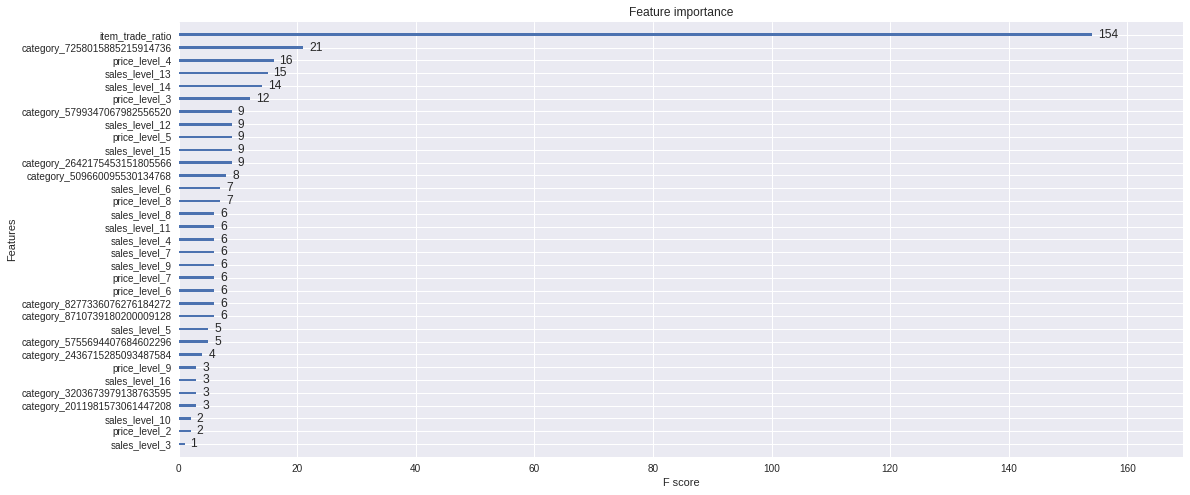

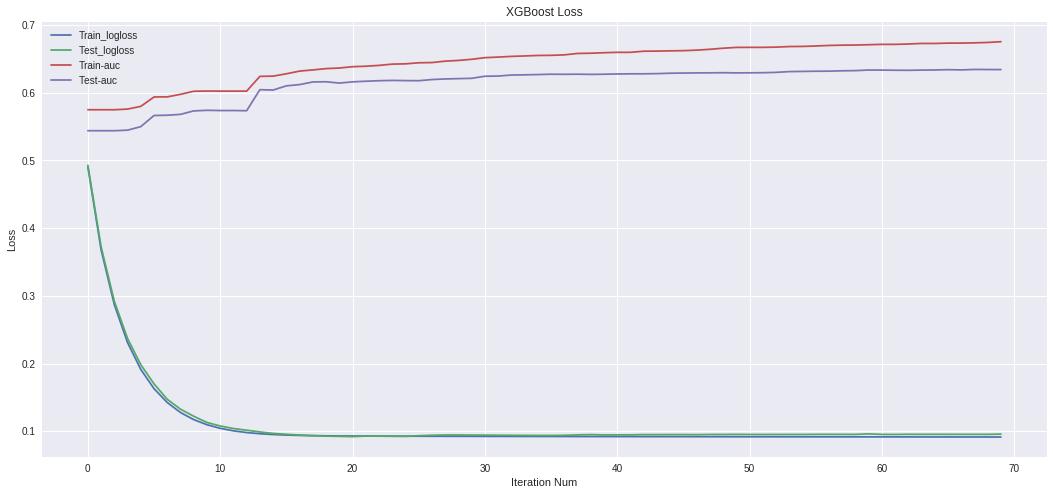

In [59]:
from matplotlib import pyplot 
from xgboost import plot_importance
#plot feature importance
ax = plot_importance(model,max_num_features=50)
fig = ax.figure
fig.set_size_inches(18, 8)
pyplot.show()

#plot logloss
epochs = len(eval_result['train']['logloss'])  
x_axis = range(0, epochs)  
fig, ax = pyplot.subplots()  
ax.plot(x_axis, eval_result['train']['logloss'], label='Train_logloss')  
ax.plot(x_axis, eval_result['test']['logloss'], label='Test_logloss')  
ax.plot(x_axis, eval_result['train']['auc'], label='Train-auc')  
ax.plot(x_axis, eval_result['test']['auc'], label='Test-auc') 
ax.legend()
fig = ax.figure
fig.set_size_inches(18, 8)
pyplot.ylabel('Loss')  
pyplot.xlabel('Iteration Num')  
pyplot.title('XGBoost Loss')  
pyplot.show()


###正式训练重新生成特征

In [0]:
#item_category_list对应的特征
category_trade_rate = get_category_trade_score(train_pd)
train_pd = set_category_trade_score(train_csv,category_trade_rate)
test_pd = set_category_trade_score(test_csv,category_trade_rate)
print(train_pd.columns)
if "category_gender_trade_score" not in feature_list:
  feature_list.append("category_gender_trade_score")
#item_brand_id特征
brand_pd = get_brand_feature(train_pd)
train_pd = set_brand_feature(train_pd,brand_pd)
test_pd = set_brand_feature(test_pd,brand_pd)
if "brand_total_ratio" not in feature_list:
  feature_list.append("brand_total_ratio")
if "brand_trade_ratio" not in feature_list:
  feature_list.append("brand_trade_ratio")
#item_city_id的特征
city_pd = get_city_feature(train_pd)
train_pd = set_city_feature(train_pd,city_pd)
test_pd = set_city_feature(test_pd,city_pd)
if "city_total_ratio" not in feature_list:
  feature_list.append("city_total_ratio")
if "city_trade_ratio" not in feature_list:
  feature_list.append("city_trade_ratio")
if "item_city_id" not in feature_list:
  feature_list.append("item_city_id")
#item_price_level特征
price_pd = get_price_feature(train_pd)
train_pd = set_price_feature(train_pd,price_pd)
test_pd = set_price_feature(test_pd,price_pd)
if "price_total_ratio" not in feature_list:
  feature_list.append("price_total_ratio")
if "price_trade_ratio" not in feature_list:
  feature_list.append("price_trade_ratio")
if "item_price_level" not in feature_list:
  feature_list.append("item_price_level")
#item_sales_level的特征
sales_pd = get_sales_feature(train_pd)
train_pd = set_sales_feature(train_pd,sales_pd)
test_pd = set_sales_feature(test_pd,sales_pd)
if "sales_total_ratio" not in feature_list:
  feature_list.append("sales_total_ratio")
if "sales_trade_ratio" not in feature_list:
  feature_list.append("sales_trade_ratio")
if "item_sales_level" not in feature_list:
  feature_list.append("item_sales_level")
#item_collected_level的特征
collected_pd = get_collected_feature(train_pd)
train_pd = set_collected_feature(train_pd,collected_pd)
test_pd = set_collected_feature(test_pd,collected_pd)
if "collected_total_ratio" not in feature_list:
  feature_list.append("collected_total_ratio")
if "collected_trade_ratio" not in feature_list:
  feature_list.append("collected_trade_ratio")
if "item_collected_level" not in feature_list:
  feature_list.append("item_collected_level")
#item_pv_level的特征
pv_pd = get_pv_feature(train_pd)
train_pd = set_pv_feature(train_pd,pv_pd)
test_pd = set_pv_feature(test_pd,pv_pd)
if "pv_total_ratio" not in feature_list:
  feature_list.append("pv_total_ratio")
if "pv_trade_ratio" not in feature_list:
  feature_list.append("pv_trade_ratio")
if "item_pv_level" not in feature_list:
  feature_list.append("item_pv_level")
#user_age_level的特征
age_pd = get_age_feature(train_pd)
train_pd = set_age_feature(train_pd,age_pd)
test_pd = set_age_feature(test_pd,age_pd)
if "age_total_ratio" not in feature_list:
  feature_list.append("age_total_ratio")
if "age_trade_ratio" not in feature_list:
  feature_list.append("age_trade_ratio")
if "user_age_level" not in feature_list:
  feature_list.append("user_age_level")
#user_occupation_id的特征
occupation_pd = get_occupation_feature(train_pd)
train_pd = set_occupation_feature(train_pd,occupation_pd)
test_pd = set_occupation_feature(test_pd,occupation_pd)
if "occupation_total_ratio" not in feature_list:
  feature_list.append("occupation_total_ratio")
if "occupation_trade_ratio" not in feature_list:
  feature_list.append("occupation_trade_ratio")
if "user_occupation_id" not in feature_list:
  feature_list.append("user_occupation_id")
#user_star_level的特征
star_pd = get_star_feature(train_pd)
train_pd = set_star_feature(train_pd,star_pd)
test_pd = set_star_feature(test_pd,star_pd)
if "star_total_ratio" not in feature_list:
  feature_list.append("star_total_ratio")
if "star_trade_ratio" not in feature_list:
  feature_list.append("star_trade_ratio")
if "user_star_level" not in feature_list:
  feature_list.append("user_star_level")
#context_page_id的特征
page_id_pd = get_page_id_feature(train_pd)
train_pd = set_page_id_feature(train_pd,page_id_pd)
test_pd = set_page_id_feature(test_pd,page_id_pd)
if "page_id_total_ratio" not in feature_list:
  feature_list.append("page_id_total_ratio")
if "page_id_trade_ratio" not in feature_list:
  feature_list.append("page_id_trade_ratio")
if "context_page_id" not in feature_list:
  feature_list.append("context_page_id")
#shop_review_num_level的特征
review_num_pd = get_review_num_feature(train_pd)
train_pd = set_review_num_feature(train_pd,review_num_pd)
test_pd = set_review_num_feature(test_pd,review_num_pd)
if "review_num_total_ratio" not in feature_list:
  feature_list.append("review_num_total_ratio")
if "review_num_trade_ratio" not in feature_list:
  feature_list.append("review_num_trade_ratio")
if "shop_review_num_level" not in feature_list:
  feature_list.append("shop_review_num_level")
#计算shop_review_positive_rate
if "shop_review_positive_rate" not in feature_list:
  feature_list.append("shop_review_positive_rate")
#计算shop_star_level的特征
shop_star_pd = get_shop_star_feature(train_pd)
train_pd = set_shop_star_feature(train_pd,shop_star_pd)
test_pd = set_shop_star_feature(test_pd,shop_star_pd)
if "shop_star_total_ratio" not in feature_list:
  feature_list.append("shop_star_total_ratio")
if "shop_star_trade_ratio" not in feature_list:
  feature_list.append("shop_star_trade_ratio")
if "shop_star_level" not in feature_list:
  feature_list.append("shop_star_level")
#shop_score_service
if "shop_score_service" not in feature_list:
  feature_list.append("shop_score_service")
#shop_score_delivery
if "shop_score_delivery" not in feature_list:
  feature_list.append("shop_score_delivery")
#shop_score_description
if "shop_score_description" not in feature_list:
  feature_list.append("shop_score_description")
#用户历史的成交数目特征
user_recent_trade_pd = cal_recent_trade_num(train_pd)
train_pd = set_user_recent_trade_num(train_pd,user_recent_trade_pd)
test_pd = set_user_recent_trade_num(test_pd,user_recent_trade_pd)
if "user_history_trade_num" not in feature_list:
  feature_list.append("user_history_trade_num") 
if "user_last_type" not in feature_list:
  feature_list.append("user_last_type") 
#item_id特征
item_id_pd = get_item_id_feature(train_pd)
train_pd = set_item_id_feature(train_pd,item_id_pd)
test_pd = set_item_id_feature(test_pd,item_id_pd)
if "item_id_total_ratio" not in feature_list:
  feature_list.append("item_id_total_ratio")
if "item_id_trade_ratio" not in feature_list:
  feature_list.append("item_id_trade_ratio")

###结果预测

In [148]:
#总训练集生成
X = train_pd[feature_list].copy()
Y = train_pd["is_trade"].copy()
train_set = xgb.DMatrix(X,label=Y)
#测试集生成
X_t = test_pd[feature_list].copy() 
test_set = xgb.DMatrix(X_t)
#训练总模型
watchlist = [(train_set,'train')]
final_model = xgb.train( param, train_set, limit,watchlist)
#预测
predict_out = final_model.predict(test_set,ntree_limit=limit)
test_pd["predicted_score"] = predict_out
result = test_pd[["instance_id","predicted_score"]].copy()

[0]	train-auc:0.837086	train-logloss:0.450941
[1]	train-auc:0.986474	train-logloss:0.316265
[2]	train-auc:0.986638	train-logloss:0.231772
[3]	train-auc:0.986734	train-logloss:0.175155
[4]	train-auc:0.986719	train-logloss:0.136783
[5]	train-auc:0.986825	train-logloss:0.108858
[6]	train-auc:0.98686	train-logloss:0.088875
[7]	train-auc:0.986887	train-logloss:0.074429
[8]	train-auc:0.98691	train-logloss:0.063904
[9]	train-auc:0.986998	train-logloss:0.056186
[10]	train-auc:0.987028	train-logloss:0.050525
[11]	train-auc:0.98706	train-logloss:0.04635
[12]	train-auc:0.987079	train-logloss:0.043275
[13]	train-auc:0.987061	train-logloss:0.041704
[14]	train-auc:0.987077	train-logloss:0.039827
[15]	train-auc:0.987073	train-logloss:0.039117
[16]	train-auc:0.987155	train-logloss:0.037843
[17]	train-auc:0.987197	train-logloss:0.036926
[18]	train-auc:0.987232	train-logloss:0.036259
[19]	train-auc:0.98725	train-logloss:0.035764
[20]	train-auc:0.987265	train-logloss:0.035676
[21]	train-auc:0.987274	trai

###结果保存

In [164]:
#保存文件
time_string = time.strftime('%Y_%m_%d_%H_%M_%S',time.localtime(time.time()+8*3600))
file_name = "drive/Colab_Notebooks/output/"+time_string+ '_'+str(model.best_score).split(".")[1]+".csv"
result.to_csv(file_name,index=False,sep=" ",float_format='%.6f')
print(file_name)

drive/Colab_Notebooks/output/2018_03_03_22_08_48_030655.csv


##sklearn

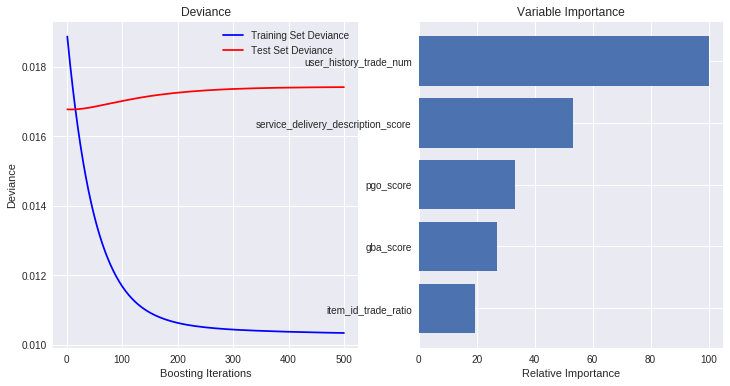

In [152]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import cross_validation, metrics
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

X_train, y_train = train_m[feature_list].copy(), train_m["is_trade"]
X_test, y_test = test_m[feature_list].copy(), test_m["is_trade"]
# Fit regression model
params = {'n_estimators': 500, 'max_depth': 4, 'min_samples_split': 2,
          'learning_rate': 0.01, 'loss': 'ls'}
clf = GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)
mse = mean_squared_error(y_test, clf.predict(X_test))

# compute test set deviance
test_score = np.zeros((params['n_estimators'],), dtype=np.float64)

for i, y_pred in enumerate(clf.staged_predict(X_test)):
    test_score[i] = clf.loss_(y_test, y_pred)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title('Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, clf.train_score_, 'b-',
         label='Training Set Deviance')
plt.plot(np.arange(params['n_estimators']) + 1, test_score, 'r-',
         label='Test Set Deviance')
plt.legend(loc='upper right')
plt.xlabel('Boosting Iterations')
plt.ylabel('Deviance')

# #############################################################################
# Plot feature importance
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, feature_list)
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [163]:
feature_list

['item_id_trade_ratio',
 'gba_score',
 'pgo_score',
 'service_delivery_description_score',
 'user_history_trade_num',
 'sales_gender_score']